# Flow refinement 
This notebook is not part of the Thesis!
Here we try to refine the flow in a Flownet-C like manner. This is part of the future work section of the thesis.

## General Ideal
Take extracted features and concatenate them with the output flow. Then use an upsampling layer and concatenate the predicted flow again. Do this twice (to keep it light weights) and generate a flow ofsiez 150x150

In [1]:
! nvidia-smi

Thu Feb 24 09:18:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
|  0%   43C    P2    56W / 250W |   8444MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:5E:00.0 Off |                  N/A |
|  0%   

In [2]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import datetime as datetime
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warp_Flow
from utils.encoding import labelMatrixOneHot, dice_coeff
import torch.utils.checkpoint
from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7fa2bdb1b5b0>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

# Data

In [3]:
imgs = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames_disp_6.pth')
segs = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs_disp_6.pth')

test_imgs = torch.load('/share/data_ultraschall/nicke_ma/data/test_frames_disp_6.pth')
test_segs = torch.load('/share/data_ultraschall/nicke_ma/data/test_segs_disp_6.pth')
#imgs = torch.rand(40,2,150,150)
#segs = torch.rand(40,2,150,150)

train_set = torch.arange(len(imgs))
test_set = torch.arange(len(test_imgs))

# Model

In [147]:
class OBELISK2d(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False,
                                groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False,
                                padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

        H = size[0]
        W = size[1]
        self.o_m = H // 4 +1
        self.o_n = W // 4 +1

        self.displace_range = 11
        self.disp_hw = 5
        self.ogrid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                 (1, 1, self.o_m, self.o_n)).view(1, 1, -1, 2).cuda()
        self.disp_range = 0.25
        self.displacement_width = 11
        shift_xy = F.affine_grid(self.disp_range * torch.eye(2, 3).unsqueeze(0), (1, 1, self.displacement_width, self.displacement_width)).view(1, 1, -1, 2).cuda()
        grid_size = 32  # 25#30
        self.grid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                (1, 1, grid_size, grid_size)).view(1, -1, 1,
                                                                   2).cuda()

    def forward(self, fixed_img, moving_img):
        img_in_f = F.avg_pool2d(fixed_img, 3, padding=1, stride=2)
        img_in_f = F.relu(self.batch0(self.layer0(img_in_f)))
        sampled_f = F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_f -= F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_1_1 = F.relu(self.batch1(self.layer1(sampled_f)))
        x_1_2 = F.relu(self.batch2(self.layer2(x_1_1)))
        features_fixed = self.layer3(x_1_2)
        
        img_in_m = F.avg_pool2d(moving_img, 3, padding=1, stride=2)
        img_in_m = F.relu(self.batch0(self.layer0(img_in_m)))
        sampled_m = F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_m -= F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_2_1 = F.relu(self.batch1(self.layer1(sampled_m)))
        x_2_2 = F.relu(self.batch2(self.layer2(x_2_1)))
        features_moving = self.layer3(x_2_2)

        ssd_distance = self.correlation_layer(features_moving, features_fixed)
        soft_cost,disp_xy = self.meanfield(ssd_distance, fixed_img, self.displace_range, self.o_m, self.o_n)
        
        return disp_xy, x_1_1, x_1_2


    def min_convolution(self, ssd_distance, displace_range, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5, stride=1)
        max1 = nn.MaxPool2d(3, stride=1)
        pad2 = nn.ReplicationPad2d(4)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(
            ssd_distance.permute(0, 2, 3, 1).reshape(1, -1, self.displace_range,
                                                    self.displace_range)))))

        ssd_minconv = ssd_minconv.permute(0, 2, 3, 1).view(1, -1, H, W)
        min_conv_cost = avg1(avg1(pad2(ssd_minconv)))

        return min_conv_cost


    def meanfield(self, ssd_distance, img_fixed, displace_range, H, W):
        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, displace_range, H, W)

        soft_cost = F.softmax(-10 * cost.view(displace_range ** 2, -1).t(), 1)

        disp_hw = (displace_range - 1) // 2
        disp_mesh_grid = disp_hw * F.affine_grid(torch.eye(2, 3).unsqueeze(0), (
        1, 1, displace_range, displace_range), align_corners=True)
        disp_mesh_grid /= torch.Tensor([(W - 1) * .5, (H - 1) * .5])

        disp_xy = torch.sum(
            soft_cost.view(1, H, W, -1, 1) * disp_mesh_grid.view(1, 1, 1, -1,
                                                                2).to(crnt_dev),
            3).permute(0, 3, 1, 2)

        return soft_cost, disp_xy


    def correlation_layer(self, feat_moving, feat_fixed):
        disp_hw = (self.displacement_width - 1) // 2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1, 0),
                                    (self.displace_range, self.displace_range),
                                    padding=self.disp_hw)
        B, C, H, W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold - feat_fixed.view(C, 1, -1)) ** 2).sum(0).view(1, displace_range ** 2, H, W)

        return ssd_distance



class PDD2D(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(PDD2D, self).__init__()
        
        self.feat_extractor = OBELISK2d(chan)
        path_to_state_dict = f'models/Experiment_2/fineTuneSoft/soft_trained.pth'
        self.feat_extractor.load_state_dict(torch.load(path_to_state_dict))
        self.feat_extractor.cuda()

        H = size[0]
        W = size[1]
        
        self.identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()


        self.deconv_1 = nn.Sequential(
                        nn.ConvTranspose2d(
                            128,
                            62,
                            kernel_size=4,
                            stride=2,
                            padding=1,
                            bias=True), nn.LeakyReLU(0.1, inplace=True))

        self.deconv_2 = nn.Sequential(
                        nn.ConvTranspose2d(
                            64,
                            32,
                            kernel_size=4,
                            stride=2,
                            padding=1,
                            bias=True), nn.LeakyReLU(0.1, inplace=True))

        self.upsamp_1 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=True)
        self.upsamp_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=True)

        self.conv_1 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1, bias=True)
        self.out = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=0, bias=True)
        #self.out = nn.Conv2d(2, 2, kernel_size=1, stride=1, padding=0, bias=True)
        

    def forward(self, fixed_img, moving_img):
       
        disp_xy, x_1_1, x_2_1 = self.feat_extractor(fixed_img.cuda(), moving_img.cuda())
        
        concat_1 = torch.cat((x_1_1, x_2_1), dim=1)
        #print("concat: ", concat_1.shape)
        out_deconv_1 = self.deconv_1(concat_1)
        #print("deconv: ", out_deconv_1.shape)
        up_flow_1 = self.upsamp_1(disp_xy)
        #print("up_1 : ", up_flow_1.shape)

        concat_2 = torch.cat((out_deconv_1, up_flow_1), dim=1)
        flow_1 = self.conv_1(concat_2)
        #print("Flow1: ", flow_1.shape)
        

        up_flow_2 = self.upsamp_2(flow_1)
        #print("flow2: ", up_flow_2.shape)
        out = self.out(up_flow_2)
        #print(out.shape)
        
        return out


In [148]:
disp_hw = 5
displace_range = 11

In [149]:
label_weights = torch.tensor([0.1,0.6, 0.3])# weights for background = 0.1, Vein = 0.6 and Artery = 0.3
epochs = 100
lr = 0.0005

H=150;W=150

model = PDD2D()
for param in model.feat_extractor.parameters():
    param.require_grad=False
model.train().cuda()

optimizer = torch.optim.Adam(list(model.parameters()),lr=lr)

In [150]:
losses = []
accs = []
unwarped = []
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)#.cuda()

for epoch in trange(epochs, desc='epoch Loop', leave=False):
    model.train()
    # Shuffle Data
    #train_set_perm = torch.randperm(len(train_set))
    #train_set = train_set[train_set_perm]
    # show all examples to model
    for i in trange(3, desc='Train Loop', leave=False):
        
        rnd_idx = train_set[i]
        p_fix = train_set[rnd_idx]
        tmp_loss = torch.zeros(3)

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float() 
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2

            
        pred = model(fixed.cuda(), moving.cuda()).cpu()
        moving_onehot = F.one_hot(moving_seg.long(), num_classes=3).float()
        # warp loss
        warped = warp(fixed_seg.unsqueeze(0).float(), pred)
        #warped = F.grid_sample(fixed_seg.unsqueeze(0).float(), identity+pred.permute(0,2,3,1))
        warp_loss = torch.sum(torch.pow(warped - moving_seg, 2)).mean()
        
        diffloss = 2.5*((pred[0,:,1:,:]-pred[0,:,:-1,:])**2).mean()+\
            2.5*((pred[0,1:,:,:]-pred[0,:-1,:,:])**2).mean()+\
            2.5*((pred[0,:,:,1:]-pred[0,:,:,:-1])**2).mean()
        
        loss = warp_loss + diffloss
        loss.backward()
        tmp_loss[i] = loss.item()
        
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(tmp_loss.mean().item())   
    tmp_acc = []
    for j in trange(1, desc="Eval loop", leave=False):
        p_fix = train_set[j]
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float() 
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2
        
        pred = model(fixed.cuda(), moving.cuda()).cpu()
        #warped_seg = F.grid_sample(fixed_seg.unsqueeze(0).float(), identity+pred.permute(0,2,3,1))
        warped_seg = warp(fixed_seg.unsqueeze(0).float(), pred)
        
        d0 = dice_coeff(warped_seg,moving_seg,3)
        print(d0)
        tmp_acc.append(d0.mean().item())
    accs.append(np.mean(tmp_acc))
    #print(np.mean(tmp_acc))

epoch Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: Given transposed=1, weight of size [2, 2, 4, 4], expected input[1, 20, 76, 76] to have 2 channels, but got 20 channels instead

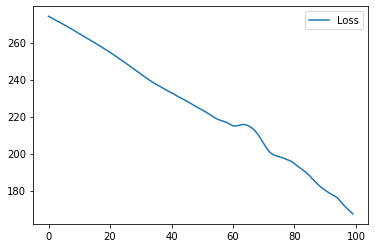

In [144]:
plt.plot(np.arange(epochs), losses, label='Loss')
plt.legend()

#plt.savefig('plots/refine_1-test.png')

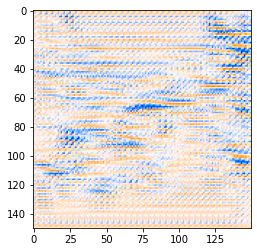

In [145]:
plt.imshow(showFlow(pred.detach()))

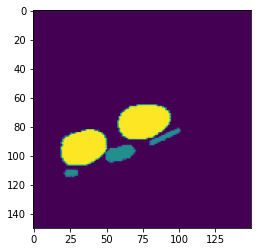

In [146]:
plt.imshow(other_warped_seg.detach().squeeze())

In [ ]:
model.eval()
accs = torch.zeros(len(test_set), 2)
un = torch.zeros(len(test_set), 2)
for j in trange(len(test_set), desc="Eval loop", leave=False):
        p_fix = test_set[j]
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float() 
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2
        
        pred = eval_model(moving.cuda(), fixed.cuda(), fixed_seg.cuda()).cpu()
        
        warped_seg = warp(fixed_seg.unsqueeze(0).float(), pred)
        
        d0 = dice_coeff(warped_seg,moving_seg,3)
        d1 = dice_coeff(fixed_seg,moving_seg,3)
        
        accs[j] = d0
        un[j] = d1

In [ ]:
torch.save(model.state_dict, 'models/refine_300.pth')

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

# Evaluation

In [5]:
eval_model = PDD2D()
eval_model.load_state_dict(torch.load('models/refine_300.pth'))

<All keys matched successfully>

In [17]:
eval_model.eval().cuda()
accs = torch.zeros(len(test_set), 2)
un = torch.zeros(len(test_set), 2)
for j in trange(len(test_set), desc="Eval loop", leave=False):
        p_fix = test_set[j]
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float() 
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2
        
        pred = eval_model(moving.cuda(), fixed.cuda(), fixed_seg.cuda()).cpu()
        
        warped_seg = warp(fixed_seg.unsqueeze(0).float(), pred)
        
        d0 = dice_coeff(warped_seg,moving_seg,3)
        d1 = dice_coeff(fixed_seg,moving_seg,3)
        
        accs[j] = d0
        un[j] = d1

Eval loop:   0%|          | 0/123 [00:00<?, ?it/s]

In [18]:
accs.mean(axis=0)

tensor([0.3804, 0.6775])

In [19]:
un.mean(axis=0)

tensor([0.3963, 0.6981])

## Eval on Videos

In [ ]:
def eval_on_id(model, frames, segs, last_segment_available):
    distance_between_frames = 6
    
    dice = torch.zeros(len(frames), 2)
    hd = torch.zeros(len(frames), 2)
    
    for i, frame in enumerate(frames):

        # skipp first X frames
        if i < distance_between_frames:
            continue
            
        if i-distance_between_frames <= last_segment_available:
            fixed = torch.clone(frames[i- distance_between_frames])
            fixed_seg = torch.clone(segs[i-distance_between_frames])
    
        if i-distance_between_frames > last_segment_available:
            fixed = torch.clone(frames[last_segment_available])
            fixed_seg = torch.clone(segs[last_segment_available])
            
        moving = torch.clone(frames[i])
        moving_seg = torch.clone(segs[i])
        
        # not segmentation available in this seg
        if moving_seg.max().item() == 0.:
            continue
        
        pred = eval_model(moving.cuda(), fixed.cuda(), fixed_seg.cuda()).cpu()
        
        warped_seg = warp(moving_seg.unsqueeze(0).float(), pred)
        
        d0 = dice_coeff(warped_seg,moving_seg,3)
        d1 = dice_coeff(fixed_seg,moving_seg,3)
    